#  download dataset
import requests


url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
r = requests.get(url, allow_redirects=True)

open('jena_climate_2009_2016.zip', 'wb').write(r.content)

# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("jena_climate_2009_2016.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="")

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
#Parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

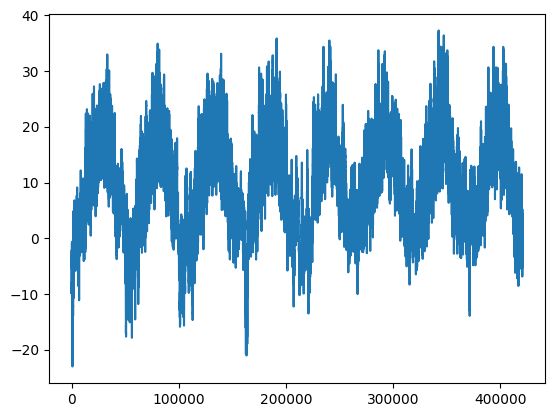

In [3]:
#Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

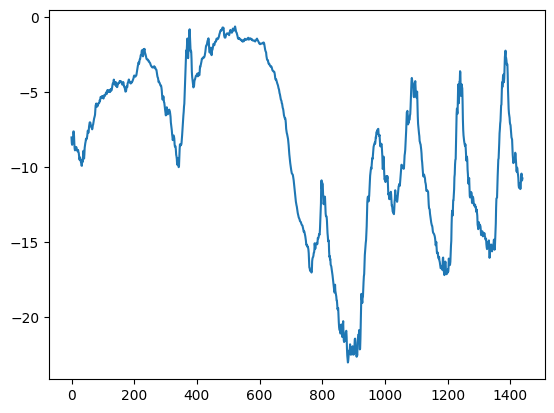

In [4]:
# Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

In [3]:
# Computing the number of samples we’ll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [4]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
import numpy as np
from tensorflow import keras


# Instantiating datasets for training, validation, and testing
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


C:\Users\reza\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [10]:
#Computing the common-sense baseline MAE

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
    


Epoch 1/10
819/819 [==============================] - 130s 147ms/step - loss: 12.0343 - mae: 2.6898 - val_loss: 10.1674 - val_mae: 2.5086
Epoch 2/10
819/819 [==============================] - 115s 139ms/step - loss: 8.7469 - mae: 2.3265 - val_loss: 10.3289 - val_mae: 2.5301
Epoch 3/10
819/819 [==============================] - 115s 140ms/step - loss: 8.0905 - mae: 2.2377 - val_loss: 11.6094 - val_mae: 2.6952
Epoch 4/10
819/819 [==============================] - 115s 140ms/step - loss: 7.6529 - mae: 2.1741 - val_loss: 10.8066 - val_mae: 2.5958
Epoch 5/10
819/819 [==============================] - 113s 137ms/step - loss: 7.3551 - mae: 2.1324 - val_loss: 12.0866 - val_mae: 2.7561
Epoch 6/10
819/819 [==============================] - 117s 143ms/step - loss: 7.0976 - mae: 2.0966 - val_loss: 12.3153 - val_mae: 2.7779
Epoch 7/10
819/819 [==============================] - 118s 143ms/step - loss: 6.9411 - mae: 2.0752 - val_loss: 11.8204 - val_mae: 2.7141
Epoch 8/10
819/819 [====================

In [12]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 38s 91ms/step - loss: 11.3223 - mae: 2.6428
Test MAE: 2.64


<function matplotlib.pyplot.show(close=None, block=None)>

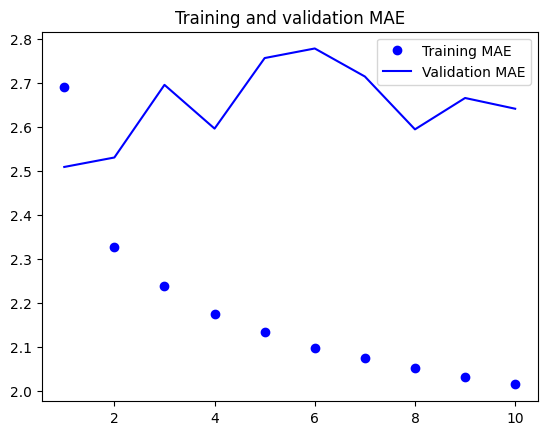

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

In [14]:
#Let’s try a 1D convolutional model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 233s 274ms/step - loss: 21.9714 - mae: 3.6673 - val_loss: 15.8201 - val_mae: 3.1629
Epoch 2/10
819/819 [==============================] - 225s 273ms/step - loss: 16.0186 - mae: 3.1928 - val_loss: 14.1879 - val_mae: 2.9646
Epoch 3/10
819/819 [==============================] - 234s 284ms/step - loss: 14.8789 - mae: 3.0740 - val_loss: 14.1788 - val_mae: 2.9717
Epoch 4/10
819/819 [==============================] - 241s 293ms/step - loss: 14.0682 - mae: 2.9838 - val_loss: 14.0668 - val_mae: 2.9469
Epoch 5/10
819/819 [==============================] - 232s 282ms/step - loss: 13.4202 - mae: 2.9099 - val_loss: 18.3648 - val_mae: 3.3866
Epoch 6/10
819/819 [==============================] - 235s 286ms/step - loss: 12.8606 - mae: 2.8430 - val_loss: 15.0650 - val_mae: 3.0469
Epoch 7/10
819/819 [==============================] - 234s 285ms/step - loss: 12.4491 - mae: 2.7950 - val_loss: 14.1302 - val_mae: 2.9681
Epoch 8/10
819/819 [==============

In [15]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 51s 122ms/step - loss: 14.7961 - mae: 3.0350
Test MAE: 3.04


<function matplotlib.pyplot.show(close=None, block=None)>

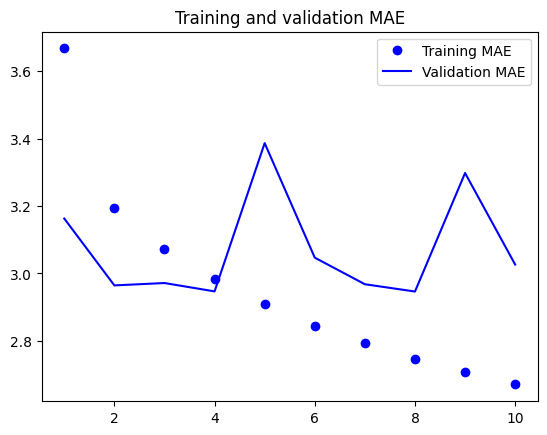

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

In [17]:
#A simple LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 282s 327ms/step - loss: 39.1909 - mae: 4.5718 - val_loss: 12.2304 - val_mae: 2.6717
Epoch 2/10
819/819 [==============================] - 270s 328ms/step - loss: 10.9937 - mae: 2.5800 - val_loss: 9.6990 - val_mae: 2.4229
Epoch 3/10
819/819 [==============================] - 269s 328ms/step - loss: 9.9658 - mae: 2.4653 - val_loss: 9.9229 - val_mae: 2.4407
Epoch 4/10
819/819 [==============================] - 265s 323ms/step - loss: 9.4615 - mae: 2.4071 - val_loss: 9.8564 - val_mae: 2.4277
Epoch 5/10
819/819 [==============================] - 272s 331ms/step - loss: 9.0072 - mae: 2.3516 - val_loss: 9.9944 - val_mae: 2.4453
Epoch 6/10
819/819 [==============================] - 272s 332ms/step - loss: 8.6412 - mae: 2.3090 - val_loss: 10.2170 - val_mae: 2.4750
Epoch 7/10
819/819 [==============================] - 277s 337ms/step - loss: 8.3211 - mae: 2.2646 - val_loss: 10.5324 - val_mae: 2.5057
Epoch 8/10
819/819 [=======================

In [18]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 75s 178ms/step - loss: 10.9587 - mae: 2.5748
Test MAE: 2.57


<function matplotlib.pyplot.show(close=None, block=None)>

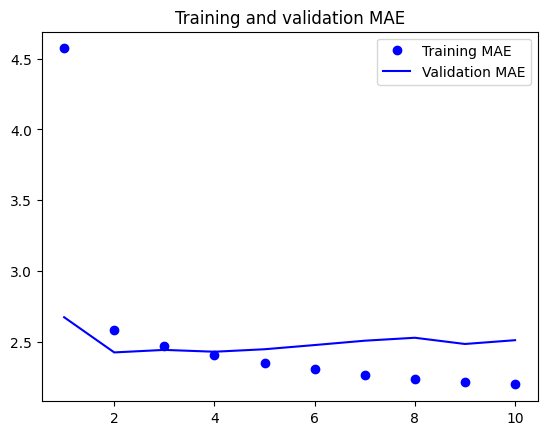

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

In [ ]:
#Training and evaluating a dropout-regularized LSTM
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

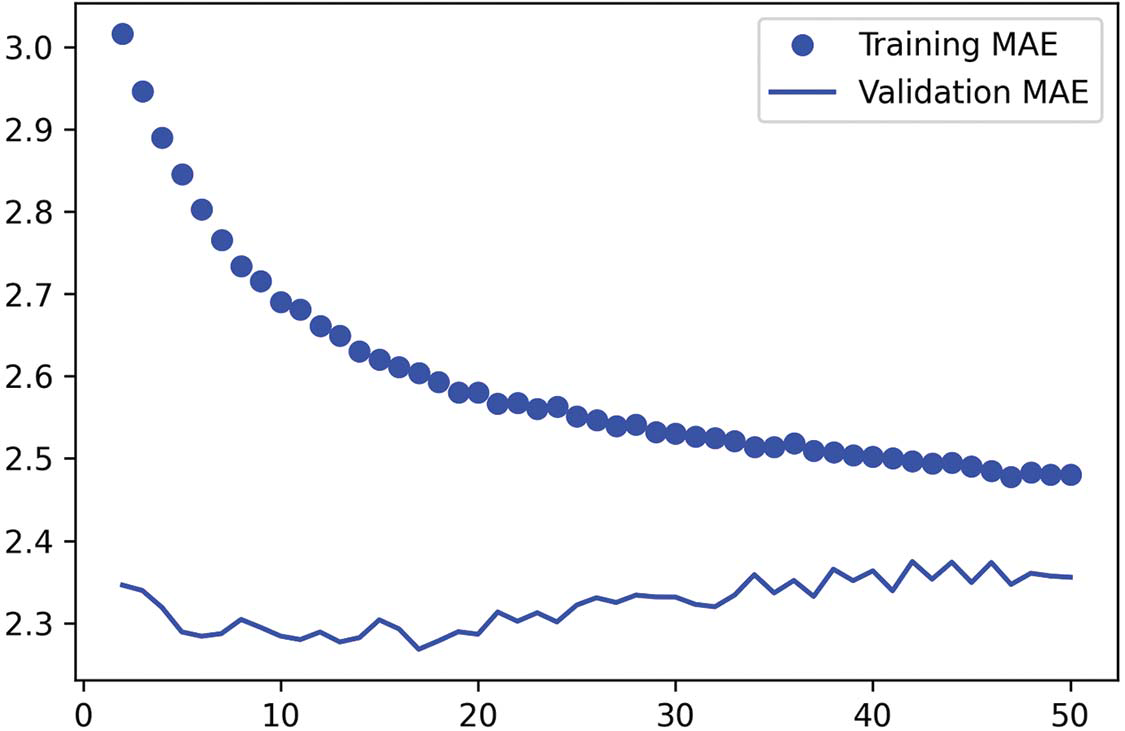


In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    history = model.fit(train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)
    
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

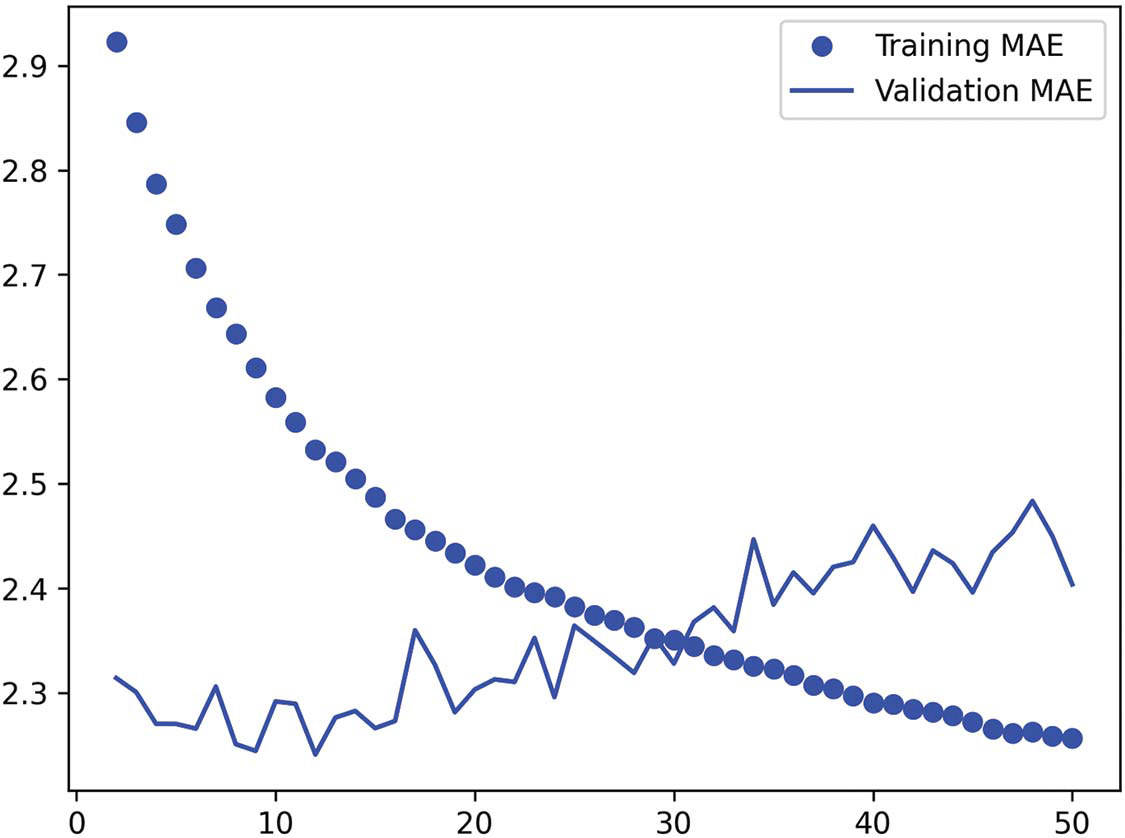

In [ ]:
# Training and evaluating a bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset)